Part 3: Depth from Stereo:

Write a program to estimate a depth map from a pair of calibrated images in Figure 4 using an MRF and graphcuts. The camera matrices are available here. Note that, for finding the epipolar lines using the provided camera matrices, you might want to use the following equation:

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gco 
import numpy as np

image_l = cv2.imread('./non_rec_left.jpg',cv2.IMREAD_COLOR)
image_l = cv2.cvtColor(image_l, cv2.COLOR_BGR2RGB)
image_r = cv2.imread('./non_rec_right.jpg',cv2.IMREAD_COLOR)
image_r = cv2.cvtColor(image_r, cv2.COLOR_BGR2RGB)
print(image_l.shape)
# Define the text representation as a string
camera_data_1 = """
1221.2270770    0.0000000    479.5000000
0.0000000    1221.2270770    269.5000000
0.0000000    0.0000000    1.0000000
1.0000000000    0.0000000000    0.0000000000
0.0000000000    1.0000000000    0.0000000000
0.0000000000    0.0000000000    1.0000000000
0.0000000000    0.0000000000    0.0000000000
"""
lines = camera_data_1.strip().split('\n')
values = [line.split() for line in lines]
C1 = np.array([[float(val) for val in line] for line in values])


camera_data_2 = """
1221.2270770    0.0000000    479.5000000
0.0000000    1221.2270770    269.5000000
0.0000000    0.0000000    1.0000000
0.9998813487    0.0148994942    0.0039106989
-0.0148907594    0.9998865876    -0.0022532664
-0.0039438279    0.0021947658    0.9999898146
-9.9909793759    0.2451742154    0.1650832670
"""
lines_p = camera_data_2.strip().split('\n')
values_p = [line.split() for line in lines_p]
C2 = np.array([[float(val) for val in line] for line in values_p])
K_1,K_2=C1[0:3, :], C2[0:3, :]
R_1,R_2=C1[3:6, :], C2[3:6, :]
T_1,T_2=C1[6,:], C2[6,:]
T_1=T_1.reshape(3,1)
T_2=T_2.reshape(3,1)
print(T_1.shape, T_2.shape)

def get_edges_and_weights(image, m_lambda, disparity):
    h, w, d = image.shape
    # h, w= 10, 10
    E = (h - 1) * w + h * (w - 1)
    edges = np.empty((E, 2), dtype=np.int32)
    edge_weights = np.ones(E, dtype=np.float)
    for i in range(len(edge_weights)):
        edge_weights[i]=m_lambda
    idx = 0
    for row in range(h):
        edges[idx:idx+w-1,0] = np.arange(w-1) + row * w
        edges[idx:idx+w-1,1] = np.arange(w-1) + row * w + 1
        idx += w-1

    # vertical edges
    for col in range(w):
        edges[idx:idx+h-1,0] = np.arange(0, (h-1)*w, w) + col
        edges[idx:idx+h-1,1] = np.arange(w, h*w, w) + col
        idx += h-1
    return [edges, edge_weights]

(540, 960, 3)
(3, 1) (3, 1)


Disparity max = 0.1

In [15]:
def measure_depth(left_image,right_image,disparity,dis_max, m_lambda): # disparity max=0.1
    d=np.linspace(0,dis_max,disparity)
    perior = np.zeros((disparity, disparity))
    for i in range(0, disparity):
        for j in range(0, disparity):
            perior[i][j] = abs(i-j)**2
            
    smooth=1-np.eye(disparity)
    fp = np.zeros([disparity,disparity])
    for d_x, x in enumerate(d) :
        for d_y, y in enumerate(d):
            fp[d_x,d_y] = abs(x-y)
                
    h_l, w_l,_= left_image.shape
    Mk_f=np.zeros([h_l*w_l,disparity])
    for row in range (h_l):
        for col in range (w_l):
            for index, dis in  enumerate(d):
                x_h=np.array([[col],[row],[1]])
                x_hp_1 = np.dot(K_2,(R_2).T)
                x_hp_2 = np.dot(x_hp_1,R_1)
                x_hp_3 = np.dot(x_hp_2,np.linalg.inv(K_1))
                x_hp=np.dot(x_hp_3,x_h)
               #  print(x_hp)
                x_hp_4 = dis*(np.dot(K_2,(R_2).T))
                temp = T_1-T_2
                x_hp = x_hp + np.dot(x_hp_4,temp)
                x_hp=np.round(x_hp/x_hp[2])
               #  print(x_hp.shape)
                d_y, d_x= int(x_hp[0]), int(x_hp[1])
                if d_y>=w_l and d_x >= h_l:
                   Mk_f[row*w_l+col][index]=np.sum(np.abs(left_image[row][col]-right_image[h_l-1][w_l-1])**2)/3
                if d_y>=w_l and 0<=d_x<h_l: 
                   Mk_f[row*w_l+col][index]=np.sum(np.abs(left_image[row][col]-right_image[int(d_x)][w_l-1])**2)/3
                if d_y>=w_l and d_x<0:
                   Mk_f[row*w_l+col][index]=np.sum(np.abs(left_image[row][col]-right_image[0][w_l-1])**2)/3
                if 0<=d_y<w_l and d_x >= h_l:   
                   Mk_f[row*w_l+col][index]=np.sum(np.abs(left_image[row][col]-right_image[h_l-1][int(d_y)])**2)/3
                if 0<=d_y<w_l and 0<=d_x<h_l:   
                   Mk_f[row*w_l+col][index]=np.sum(np.abs(left_image[row][col]-right_image[int(d_x)][int(d_y)])**2)/3
                if 0<=d_y<w_l and d_x<0:    
                   Mk_f[row*w_l+col][index]=np.sum(np.abs(left_image[row][col]-right_image[0][int(d_y)])**2)/3
                if d_y<0 and d_x >= h_l:
                   Mk_f[row*w_l+col][index]=np.sum(np.abs(left_image[row][col]-right_image[h_l-1][0])**2)/3
                if d_y<0 and 0<=d_x<h_l: 
                   Mk_f[row*w_l+col][index]=np.sum(np.abs(left_image[row][col]-right_image[int(d_x)][0])**2)/3 
                if d_y<0 and d_x<0:
                   Mk_f[row*w_l+col][index]=np.sum(np.abs(left_image[row][col]-right_image[0][0])**2)/3
                
    edges, edge_weights=get_edges_and_weights(left_image, m_lambda , disparity)
   #  print(edges, edge_weights)
    labels = gco.cut_general_graph(edges, edge_weights, Mk_f, perior, n_iter=-1,algorithm='swap')
    # labels=gco.cut_grid_graph_simple(Mk_f, smooth*0.5, n_iter=-1)
    labels = labels.reshape(h_l,w_l)    
    plt.imshow(labels,'gray')
    
    
   

Disparity max = 1

/tmp/ipykernel_978/810700524.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d_y, d_x= int(x_hp[0]), int(x_hp[1])


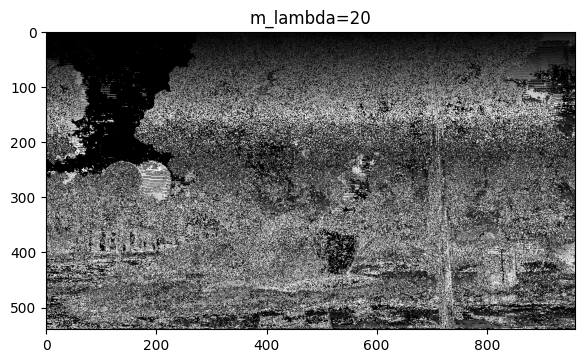

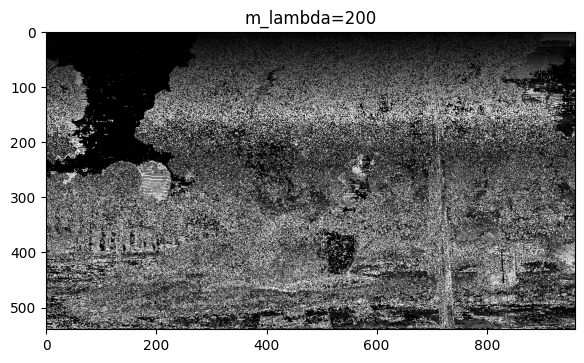

In [17]:
plt.figure(figsize=(15,15))
plt.subplot(321)
plt.title('m_lambda=20')
measure_depth(left_image=image_l, right_image=image_r,disparity=50,dis_max=1,m_lambda=20)
plt.figure(figsize=(15,15))
plt.subplot(322)
plt.title('m_lambda=200')
measure_depth(left_image=image_l, right_image=image_r,disparity=50,dis_max=1,m_lambda=200)



Disparity max = 0.1

/tmp/ipykernel_978/810700524.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d_y, d_x= int(x_hp[0]), int(x_hp[1])


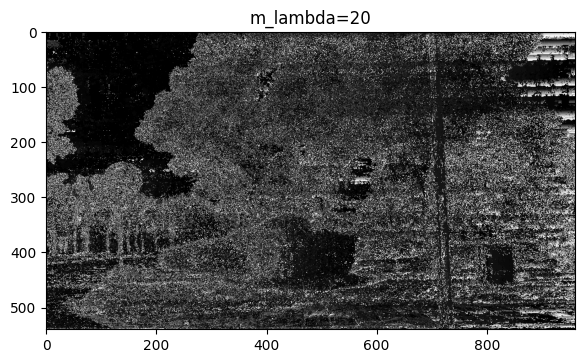

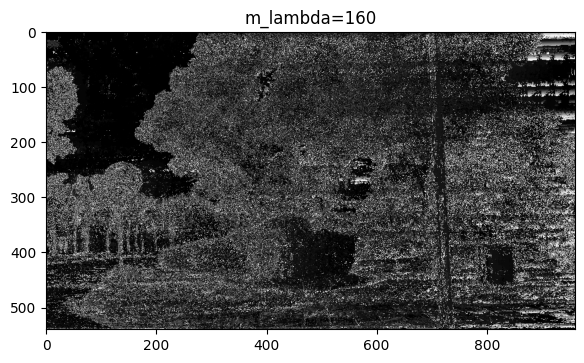

In [18]:
plt.figure(figsize=(15,15))
plt.subplot(321)
plt.title('m_lambda=20')
measure_depth(left_image=image_l, right_image=image_r,disparity=50,dis_max=0.1,m_lambda=20)
plt.figure(figsize=(15,15))
plt.subplot(322)
plt.title('m_lambda=160')
measure_depth(left_image=image_l, right_image=image_r,disparity=50,dis_max=0.1,m_lambda=160)


Disparity max = 0.05

/tmp/ipykernel_978/810700524.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d_y, d_x= int(x_hp[0]), int(x_hp[1])


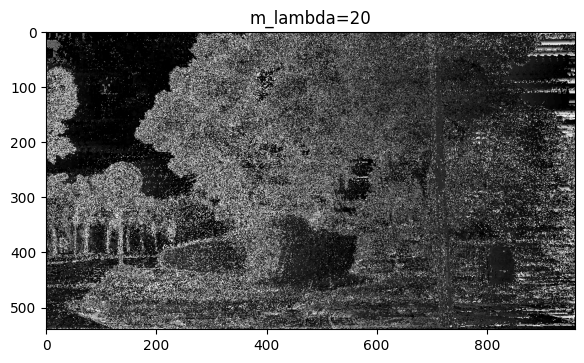

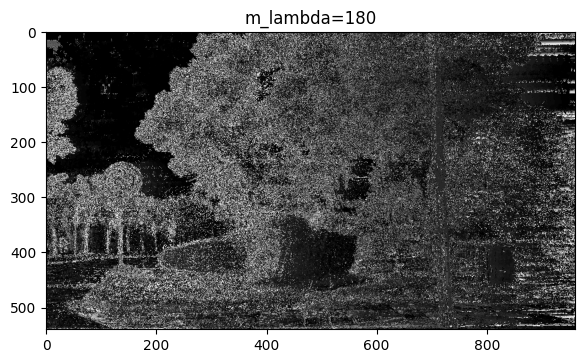

In [19]:
plt.figure(figsize=(15,15))
plt.subplot(321)
plt.title('m_lambda=20')
measure_depth(left_image=image_l, right_image=image_r,disparity=50,dis_max=0.05, m_lambda=20)
plt.figure(figsize=(15,15))
plt.subplot(322)
plt.title('m_lambda=180')
measure_depth(left_image=image_l, right_image=image_r,disparity=50,dis_max=0.05, m_lambda=180)


Disparity max=0.015

/tmp/ipykernel_978/810700524.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d_y, d_x= int(x_hp[0]), int(x_hp[1])


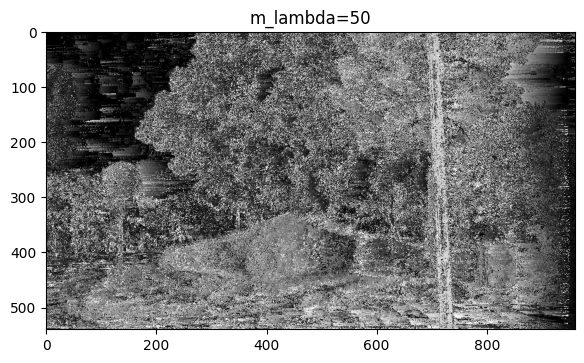

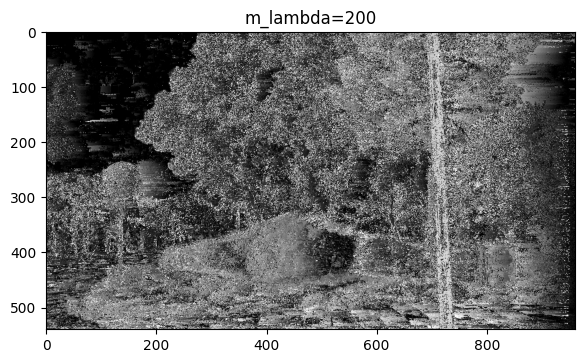

In [14]:
plt.figure(figsize=(15,15))
plt.subplot(321)
plt.title('m_lambda=50')
measure_depth(left_image=image_l, right_image=image_r,disparity=50,dis_max=0.015,m_lambda=10)
plt.figure(figsize=(15,15))
plt.subplot(322)
plt.title('m_lambda=200')
measure_depth(left_image=image_l, right_image=image_r,disparity=50,dis_max=0.015,m_lambda=200)


Revise distance calculation from (a-b)**2 to abs(a-b) can reduce the calculation error in the data term.

Following result is obtained without using square in calculation

/tmp/ipykernel_978/2986112886.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d_y, d_x= int(x_hp[0]), int(x_hp[1])


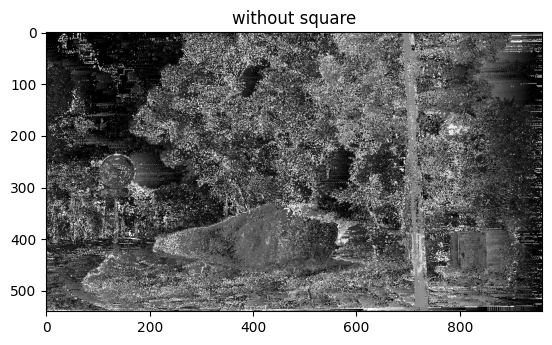

In [20]:
def measure_depth(left_image,right_image,disparity,dis_max, m_lambda): # disparity max=0.1
    d=np.linspace(0,dis_max,disparity)
    perior = np.zeros((disparity, disparity))
    for i in range(0, disparity):
        for j in range(0, disparity):
            perior[i][j] = abs(i-j)
            
    smooth=1-np.eye(disparity)
    fp = np.zeros([disparity,disparity])
    for d_x, x in enumerate(d) :
        for d_y, y in enumerate(d):
            fp[d_x,d_y] = abs(x-y)
                
    h_l, w_l,_= left_image.shape
    Mk_f=np.zeros([h_l*w_l,disparity])
    for row in range (h_l):
        for col in range (w_l):
            for index, dis in  enumerate(d):
                x_h=np.array([[col],[row],[1]])
                x_hp_1 = np.dot(K_2,(R_2).T)
                x_hp_2 = np.dot(x_hp_1,R_1)
                x_hp_3 = np.dot(x_hp_2,np.linalg.inv(K_1))
                x_hp=np.dot(x_hp_3,x_h)
               #  print(x_hp)
                x_hp_4 = dis*(np.dot(K_2,(R_2).T))
                temp = T_1-T_2
                x_hp = x_hp + np.dot(x_hp_4,temp)
                x_hp=np.round(x_hp/x_hp[2])
               #  print(x_hp.shape)
                d_y, d_x= int(x_hp[0]), int(x_hp[1])
                if d_y>=w_l and d_x >= h_l:
                   Mk_f[row*w_l+col][index]=np.sum(np.abs(left_image[row][col]-right_image[h_l-1][w_l-1]))/3
                if d_y>=w_l and 0<=d_x<h_l: 
                   Mk_f[row*w_l+col][index]=np.sum(np.abs(left_image[row][col]-right_image[int(d_x)][w_l-1]))/3
                if d_y>=w_l and d_x<0:
                   Mk_f[row*w_l+col][index]=np.sum(np.abs(left_image[row][col]-right_image[0][w_l-1]))/3
                if 0<=d_y<w_l and d_x >= h_l:   
                   Mk_f[row*w_l+col][index]=np.sum(np.abs(left_image[row][col]-right_image[h_l-1][int(d_y)]))/3
                if 0<=d_y<w_l and 0<=d_x<h_l:   
                   Mk_f[row*w_l+col][index]=np.sum(np.abs(left_image[row][col]-right_image[int(d_x)][int(d_y)]))/3
                if 0<=d_y<w_l and d_x<0:    
                   Mk_f[row*w_l+col][index]=np.sum(np.abs(left_image[row][col]-right_image[0][int(d_y)]))/3
                if d_y<0 and d_x >= h_l:
                   Mk_f[row*w_l+col][index]=np.sum(np.abs(left_image[row][col]-right_image[h_l-1][0]))/3
                if d_y<0 and 0<=d_x<h_l: 
                   Mk_f[row*w_l+col][index]=np.sum(np.abs(left_image[row][col]-right_image[int(d_x)][0]))/3 
                if d_y<0 and d_x<0:
                   Mk_f[row*w_l+col][index]=np.sum(np.abs(left_image[row][col]-right_image[0][0]))/3
                
    edges, edge_weights=get_edges_and_weights(left_image, m_lambda , disparity)
   #  print(edges, edge_weights)
    labels = gco.cut_general_graph(edges, edge_weights, Mk_f, perior, n_iter=-1,algorithm='swap')
    # labels=gco.cut_grid_graph_simple(Mk_f, smooth*0.5, n_iter=-1)
    labels = labels.reshape(h_l,w_l)    
    plt.imshow(labels,'gray')
    
plt.title('without square')
measure_depth(left_image=image_l, right_image=image_r,disparity=50,dis_max=0.015,m_lambda=0.01)
    
   

Show your best result, and provide some discussion if necessary (particularly if the results are not as good as expected).

Discussion: 

The result of the depth figure demonstrates the noise and ambiguity of specific details. As m_lambda increases, more noise pixels will be denoised, however, it will also lead to the loss of edges and details of trees and stones that are in the middle depth of the image. In order to obtain a better result, m_lambda should depend on x instead of being a uniform value.

Secondly, the choice of disparity also affects the result of the image. As the maxiumn of disparity increase, the pixel from the left image will obtain a higher possibility of finding the pixel at the right image but not the authentic point in the real word, consequently, making the depth map less likely ressemble the original image (failure of the experiment)

Thirdly, the quality of depth prediction may be optimized if the edge_weights= m_lambda is not uniform. However, it haven't been testified so far.

As a result, the best reuslt among Part_3 is achieved when  disparity_max= 0.015, m_lambda= 200, the figure is shown above. 

Or using abs in calculation disparity_max=0.015, m_lambda= 0.